In [1]:
import argparse
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import json
import h5py
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr

pd.set_option('display.max_columns', None)

## Load Data and Find Min/Max Bounds

In [2]:
df_cohort = pd.read_csv("/deep/group/physiologic-states/v3/matched-cohort.csv")
print(df_cohort.shape)
df_cohort.head(3)

(63624, 46)


,Unnamed: 0,CSN,Age,Gender,CC,Triage_acuity,Arrival_time,Arrival_area,Admit_area,First_room,Roomed_time,First_bed,Last_bed,ED_dispo,DC_dispo,Dispo_time,Admit_time,Departure_time,Admit_service,ED_LOS,Dx_ICD9,Dx_ICD10,Dx_name,Arrival_to_roomed,CC_CP_SOB,SpO2,RR,HR,Temp,SBP,DBP,CSN_char,Athero,HTN,HLD,DM,Obese,Smoking,DVT_PE,Malignancy,VS_measurements,Num_VS_states,Num_state_changes,study_matched,final_export_df_ids,final_studies
0,2661,131291423319,19,M,FB SKIN,4-Semi-Urgent,2020-08-20T13:57:00Z,SHC ED 500P ED LOBBY,SHC ED 500P FAST TRACK,FT04,2020-08-20T14:05:00Z,FT04,FT04,Discharge,Home/Work (includes foster care),2020-08-20T14:15:00Z,NaN,2020-08-20T14:26:00Z,NaN,0.48,"931, E915",T16.2XXA,"Foreign body of left ear, initial encounter",8,0,98.0,18.0,81.0,36.9,145.0,87.0,131291423319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,True,110,STUDY-014889
1,2664,131291426215,57,F,HAND PAIN,4-Semi-Urgent,2020-08-20T14:22:00Z,SHC ED 500P ED LOBBY,SHC ED 500P FAST TRACK,FT03,2020-08-20T14:31:00Z,FT03,FT03,Discharge,Home/Work (includes foster care),2020-08-20T15:06:00Z,NaN,2020-08-20T15:05:00Z,NaN,0.72,"V58.89, 879.8",W55.01XD,"Cat bite, subsequent encounter",9,0,97.0,18.0,62.0,36.4,126.0,67.0,131291426215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,True,186,STUDY-014968
2,2669,131291431737,20,M,URINARY FREQUENCY,4-Semi-Urgent,2020-08-20T15:06:00Z,SHC ED 500P ED LOBBY,SHC ED 500P FAST TRACK,FT04,2020-08-20T15:18:00Z,FT04,FT04,Discharge,Home/Work (includes foster care),2020-08-20T18:58:00Z,NaN,2020-08-20T19:53:00Z,NaN,4.78,788.1,R30.0,Dysuria,12,0,100.0,18.0,140.0,36.2,145.0,83.0,131291431737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,0,True,110,STUDY-014889


In [3]:
df_cohort = pd.read_csv("/deep/group/ed-monitor-self-supervised/v4/matched-cohort.csv")
print(df_cohort.shape)
df_cohort.head(3)

(90195, 34)


,Unnamed: 0,CSN,Age,Gender,CC,Triage_acuity,Arrival_time,Arrival_area,Admit_area,First_room,Roomed_time,First_bed,Last_bed,ED_dispo,DC_dispo,Dispo_time,Admit_time,Departure_time,Admit_service,ED_LOS,Dx_ICD9,Dx_ICD10,Dx_name,Arrival_to_roomed,CC_CP_SOB,SpO2,RR,HR,Temp,SBP,DBP,study_matched,final_export_df_ids,final_studies
0,2784,131291423319,19,M,FB SKIN,4-Semi-Urgent,2020-08-20T13:57:00Z,SHC ED 500P ED LOBBY,SHC ED 500P FAST TRACK,FT04,2020-08-20T14:05:00Z,FT04,FT04,Discharge,Home/Work (includes foster care),2020-08-20T14:15:00Z,NaN,2020-08-20T14:26:00Z,NaN,0.48,"931, E915",T16.2XXA,"Foreign body of left ear, initial encounter",8,0,98.0,18.0,81.0,36.9,145.0,87.0,True,110,STUDY-014889
1,2785,131291424879,21,F,ABDOMINAL PAIN,4-Semi-Urgent,2020-08-20T14:10:00Z,SHC ED 500P ED LOBBY,SHC ED 500P FAST TRACK,FT03,2020-08-20T14:21:00Z,FT03,FT03,Discharge,Home/Work (includes foster care),2020-08-20T18:08:00Z,NaN,2020-08-20T18:14:00Z,NaN,4.07,623.8,N93.9,Vaginal spotting,11,0,100.0,18.0,70.0,36.6,127.0,62.0,True,186,STUDY-014968
2,2787,131291426215,57,F,HAND PAIN,4-Semi-Urgent,2020-08-20T14:22:00Z,SHC ED 500P ED LOBBY,SHC ED 500P FAST TRACK,FT03,2020-08-20T14:31:00Z,FT03,FT03,Discharge,Home/Work (includes foster care),2020-08-20T15:06:00Z,NaN,2020-08-20T15:05:00Z,NaN,0.72,"V58.89, 879.8",W55.01XD,"Cat bite, subsequent encounter",9,0,97.0,18.0,62.0,36.4,126.0,67.0,True,186,STUDY-014968


In [4]:
df_cohort[df_cohort["CSN"] == 131322272021]

,Unnamed: 0,CSN,Age,Gender,CC,Triage_acuity,Arrival_time,Arrival_area,Admit_area,First_room,Roomed_time,First_bed,Last_bed,ED_dispo,DC_dispo,Dispo_time,Admit_time,Departure_time,Admit_service,ED_LOS,Dx_ICD9,Dx_ICD10,Dx_name,Arrival_to_roomed,CC_CP_SOB,SpO2,RR,HR,Temp,SBP,DBP,study_matched,final_export_df_ids,final_studies
70486,80630,131322272021,73,M,BLOOD IN VOMIT,3-Urgent,2021-12-27T00:03:00Z,SHC ED 500P ED LOBBY,SHC ED 500P ALPHA Y ZONE,A17,2021-12-27T00:33:00Z,A17,A17,Admit to Inpatient,Home/Work (includes foster care),2021-12-27T04:52:00Z,2021-12-27T05:05:00Z,2021-12-27T06:09:00Z,Critical Care,6.1,250.12,E11.10,Diabetic ketoacidosis without coma associated ...,30,0,96.0,19.0,110.0,37.2,108.0,47.0,True,"49769,50301","STUDY-180101,STUDY-180633"


In [5]:
df_states_all = pd.read_csv("/deep/group/physiologic-states/v3/coverage_2022_02_17.csv")
print(df_states_all.shape)
df_states_all.head(3)

(17147044, 17)


,CSN,Variable,Time,Triage,Chart_filled,Charted,Monitor,Low_bound,High_bound,CSN_char,Coverage,Arrival_time,Roomed_time,Minutes_since_arrival,Arrival_to_roomed,Covered,Coverage_without
0,131291536204,HR,2020-08-24T00:36:00Z,1,86.0,86.0,NaN,81.0,91.0,131291536204,0.15748,2020-08-24T00:36:00Z,2020-08-24T01:03:00Z,0,27,NaN,NaN
1,131291536204,HR,2020-08-24T01:08:00Z,0,86.0,NaN,73.521739,81.0,91.0,131291536204,0.15748,2020-08-24T00:36:00Z,2020-08-24T01:03:00Z,32,27,0.0,NaN
2,131291536204,HR,2020-08-24T01:09:00Z,0,86.0,NaN,72.728814,81.0,91.0,131291536204,0.15748,2020-08-24T00:36:00Z,2020-08-24T01:03:00Z,33,27,0.0,NaN


In [6]:
df_states_all = df_states_all[~df_states_all["Monitor"].isna()]
df_states_all.shape

(17043220, 17)

In [7]:
gb = df_states_all.groupby(['CSN'])
df_states_all_gb = gb.agg({'Time' : [np.min, np.max]})

In [8]:
df_states_all_gb.head(3)

Time                      
                              amin                  amax
CSN                                                     
131291536204  2020-08-24T01:08:00Z  2020-08-24T05:21:00Z
131291536239  2020-08-24T00:46:00Z  2020-08-24T03:48:00Z
131291536535  2020-08-24T01:53:00Z  2020-08-24T03:17:00Z

In [9]:
csn_to_max_time = {}
csn_to_min_time = {}
for i, row in tqdm(df_states_all_gb.iterrows()):
    csn = row.name
    
    min_time = datetime.datetime.strptime(row["Time"]["amin"], "%Y-%m-%dT%H:%M:%S%z")
    max_time = datetime.datetime.strptime(row["Time"]["amax"], "%Y-%m-%dT%H:%M:%S%z")
    csn_to_min_time[csn] = min_time
    csn_to_max_time[csn] = max_time

25956it [00:10, 2543.31it/s]


## Nurse Charted Event Placements

In [10]:
df_states = pd.read_csv("/deep/group/physiologic-states/v3/coverage_2022_02_17.charted.csv")
print(df_states.shape)
df_states.head(3)

(462580, 18)


,Unnamed: 0,CSN,Variable,Time,Triage,Chart_filled,Charted,Monitor,Low_bound,High_bound,CSN_char,Coverage,Arrival_time,Roomed_time,Minutes_since_arrival,Arrival_to_roomed,Covered,Coverage_without
0,0,131291536204,HR,2020-08-24T00:36:00Z,1,86.0,86.0,NaN,81.0,91.0,131291536204,0.15748,2020-08-24T00:36:00Z,2020-08-24T01:03:00Z,0,27,NaN,NaN
1,63,131291536204,HR,2020-08-24T02:10:00Z,0,86.0,86.0,67.474576,81.0,91.0,131291536204,0.15748,2020-08-24T00:36:00Z,2020-08-24T01:03:00Z,94,27,0.0,0.158103
2,69,131291536204,HR,2020-08-24T02:16:00Z,0,70.0,70.0,67.237288,65.0,75.0,131291536204,0.15748,2020-08-24T00:36:00Z,2020-08-24T01:03:00Z,100,27,1.0,0.059289


In [11]:
df_states_nontriage = df_states[df_states["Triage"] == 0]
print(df_states_nontriage.shape)
df_states_nontriage.head(3)

(358838, 18)


,Unnamed: 0,CSN,Variable,Time,Triage,Chart_filled,Charted,Monitor,Low_bound,High_bound,CSN_char,Coverage,Arrival_time,Roomed_time,Minutes_since_arrival,Arrival_to_roomed,Covered,Coverage_without
1,63,131291536204,HR,2020-08-24T02:10:00Z,0,86.0,86.0,67.474576,81.0,91.0,131291536204,0.15748,2020-08-24T00:36:00Z,2020-08-24T01:03:00Z,94,27,0.0,0.158103
2,69,131291536204,HR,2020-08-24T02:16:00Z,0,70.0,70.0,67.237288,65.0,75.0,131291536204,0.15748,2020-08-24T00:36:00Z,2020-08-24T01:03:00Z,100,27,1.0,0.059289
3,221,131291536204,HR,2020-08-24T04:48:00Z,0,70.0,70.0,55.796610,65.0,75.0,131291536204,0.15748,2020-08-24T00:36:00Z,2020-08-24T01:03:00Z,252,27,0.0,0.158103


In [12]:
def get_relative_placement_data(df):
    relative_placements = []

    for i, row in tqdm(df.iterrows()):
        csn = row["CSN"]
        time = row["Time"]
        time = datetime.datetime.strptime(time, "%Y-%m-%dT%H:%M:%S%z")
        
        min_time = csn_to_min_time[csn]
        max_time = csn_to_max_time[csn]
        
#         if time < min_time or time > max_time:
#             # Ignore any measures that weren't in the monitoring bounds
#             continue

        time = max(min_time, time)
        time = min(max_time, time)
        
        time_since_arrival = (time - min_time).total_seconds()
        total_time = (max_time - min_time).total_seconds()

        if total_time > 0:
            relative_time = time_since_arrival / total_time
            relative_placements.append(relative_time)

    return relative_placements
    

In [13]:
def get_relative_placement_data_at_index(df, index=0):
    relative_placements = []
    csn_to_curr_index = {}

    for i, row in tqdm(df.iterrows()):
        csn = row["CSN"]
        if csn not in csn_to_curr_index:
            csn_to_curr_index[csn] = 0
        else:
            csn_to_curr_index[csn] += 1
        
        if csn_to_curr_index[csn] == index:
            time = row["Time"]
            time = datetime.datetime.strptime(time, "%Y-%m-%dT%H:%M:%S%z")
            min_time = csn_to_min_time[csn]
            max_time = csn_to_max_time[csn]

#             if time < min_time or time > max_time:
#                 # Ignore any measures that weren't in the monitoring bounds
#                 continue

            time = max(min_time, time)
            time = min(max_time, time)

            time_since_arrival = (time - min_time).total_seconds()
            total_time = (max_time - min_time).total_seconds()

            if total_time > 0:
                relative_time = time_since_arrival / total_time
                relative_placements.append(relative_time)

    return relative_placements
    

### HR 

In [37]:
df_states_nontriage_hr = df_states_nontriage[df_states_nontriage["Variable"] == "HR"]
print(df_states_nontriage_hr.shape)

(89726, 18)


In [38]:
relative_placements = get_relative_placement_data(df_states_nontriage_hr)
print(len(relative_placements))

89726it [00:07, 11266.25it/s]

89726


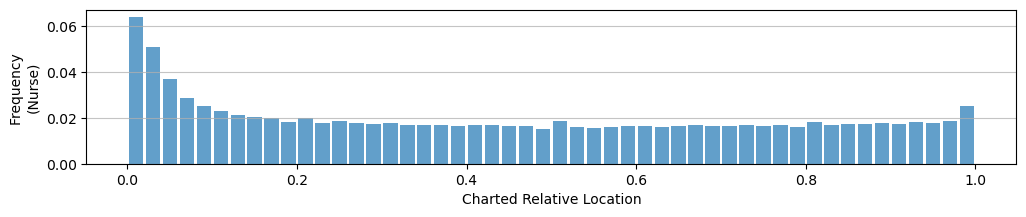

In [39]:
a4_dims = (12, 2)
fig, ax = plt.subplots(figsize=a4_dims)
weights = np.ones_like(relative_placements)/float(len(relative_placements))
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85, weights=weights)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency \n(Nurse)')
# plt.ylim([0, 0.25])
plt.show()

89726it [00:14, 6033.24it/s]


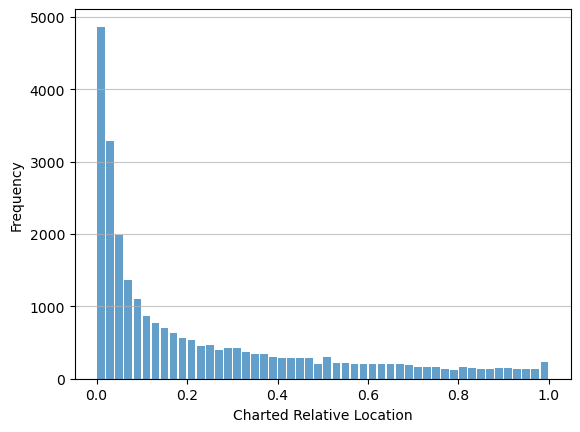

In [152]:
# Where does the first nursing measure occur relative to the charted data?

relative_placements_index_0 = get_relative_placement_data_at_index(df_states_nontriage_hr, 0)
plt.hist(relative_placements_index_0, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

89726it [00:14, 6146.00it/s]


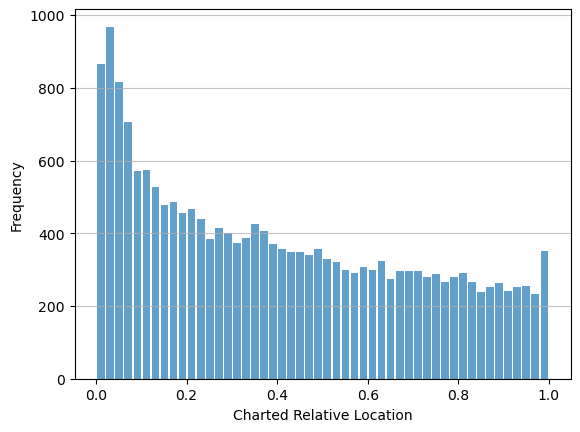

In [153]:
# Where does the second nursing measure occur relative to the charted data?

relative_placements_index_1 = get_relative_placement_data_at_index(df_states_nontriage_hr, 1)
plt.hist(relative_placements_index_1, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

89726it [00:14, 6402.14it/s]


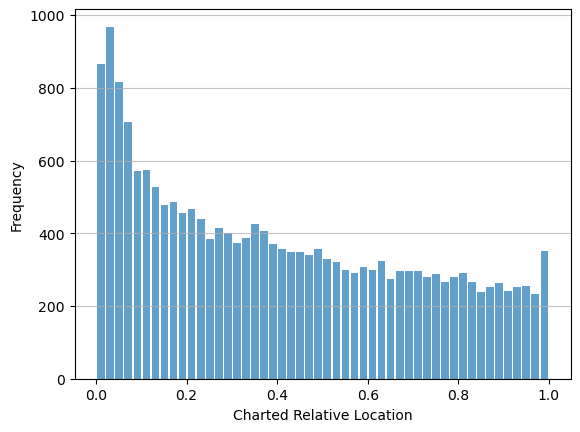

In [154]:
# Where does the third nursing measure occur relative to the charted data?

relative_placements_index_3 = get_relative_placement_data_at_index(df_states_nontriage_hr, 3)
plt.hist(relative_placements_index_1, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

### RR 

In [155]:
df_states_nontriage_hr = df_states_nontriage[df_states_nontriage["Variable"] == "RR"]
print(df_states_nontriage_hr.shape)

(89706, 18)


In [156]:
relative_placements = get_relative_placement_data(df_states_nontriage_hr)

89706it [00:17, 5011.75it/s]


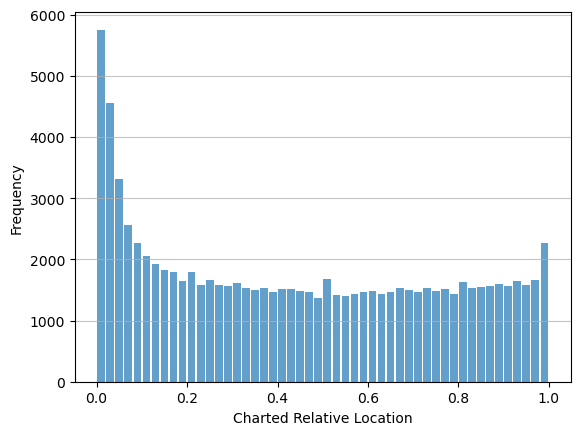

In [157]:
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

### SpO2 

In [158]:
df_states_nontriage_hr = df_states_nontriage[df_states_nontriage["Variable"] == "SpO2"]
print(df_states_nontriage_hr.shape)

(89704, 18)


In [159]:
relative_placements = get_relative_placement_data(df_states_nontriage_hr)

89704it [00:17, 5012.19it/s]


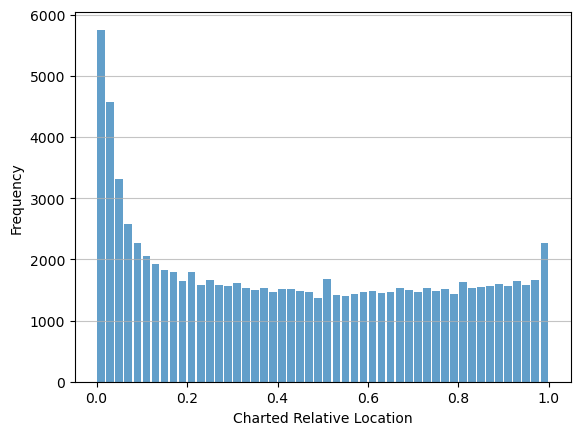

In [160]:
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

### MAP 

In [161]:
df_states_nontriage_hr = df_states_nontriage[df_states_nontriage["Variable"] == "MAP"]
print(df_states_nontriage_hr.shape)

(89702, 18)


In [162]:
relative_placements = get_relative_placement_data(df_states_nontriage_hr)

89702it [00:17, 5036.84it/s]


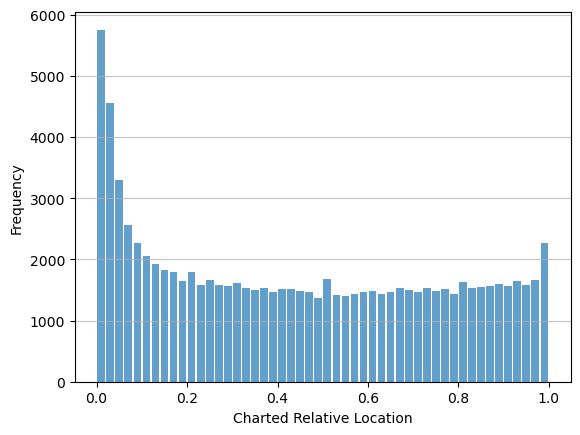

In [163]:
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

## Optimal Charted Event Placement

In [28]:
def get_optimal_relative_placement_data(b, index_to_csn):
    relative_placements = []
    csn_to_index = {}

    for i, row in tqdm(enumerate(b["output_times"])):
        csn = index_to_csn[i]
        min_time = csn_to_min_time[csn].replace(tzinfo=None)
        max_time = csn_to_max_time[csn].replace(tzinfo=None)

        for time in row:
            time = time.replace(tzinfo=None)
            if time < min_time or time > max_time:
                # Ignore any measures that weren't in the monitoring bounds
                continue

            time_since_arrival = (time - min_time).total_seconds()
            total_time = (max_time - min_time).total_seconds()

            if total_time > 0:
                relative_time = time_since_arrival / total_time
                relative_placements.append(relative_time)

    return relative_placements
    

In [29]:
def get_optimal_relative_placement_data_at_index(b, index_to_csn, index):
    relative_placements = []

    csn_to_curr_index = {}
    for i, row in tqdm(enumerate(b["output_times"])):
        csn = index_to_csn[i]
        min_time = csn_to_min_time[csn].replace(tzinfo=None)
        max_time = csn_to_max_time[csn].replace(tzinfo=None)

        for j, time in enumerate(row):
            if csn not in csn_to_curr_index:
                csn_to_curr_index[csn] = 0
            else:
                csn_to_curr_index[csn] += 1

            if csn_to_curr_index[csn] == index:
                time = time.replace(tzinfo=None)
                if time < min_time or time > max_time:
                    # Ignore any measures that weren't in the monitoring bounds
                    continue

                time_since_arrival = (time - min_time).total_seconds()
                total_time = (max_time - min_time).total_seconds()

                if total_time > 0:
                    relative_time = time_since_arrival / total_time
                    relative_placements.append(relative_time)

    return relative_placements
    

### All

In [64]:
df_optimal = pd.read_csv("/deep/group/physiologic-states/v3/optimizing_coverage.optimal.csv")
print(df_optimal.shape)
df_optimal.head(3)

(25930, 19)


,Unnamed: 0,CSN,orig_len,orig_covered,orig_total,orig_coverage,best_len,best_covered,best_total,best_coverage,HR_covered,HR_total,RR_covered,RR_total,SpO2_covered,SpO2_total,MAP_covered,MAP_total,runtime
0,0,131316325120,2,502,778,0.645244,2,1091,1260,0.865873,151,220,154,220,294,297,28,41,121.742869
1,1,131298896241,5,335,517,0.647969,2,134,134,1.000000,0,131,0,131,134,134,0,121,18.168598
2,2,131316322281,2,250,539,0.463822,2,355,437,0.812357,143,154,86,154,126,141,0,90,21.507338


In [65]:
csn_to_min_time[131316325120]

datetime.datetime(2021, 9, 17, 17, 19, tzinfo=datetime.timezone.utc)

In [66]:
index_to_csn = {}
for k, row in df_optimal.iterrows():
    index_to_csn[k] = row["CSN"]

In [67]:
with open("/deep/group/physiologic-states/v3/optimizing_coverage.optimal.pkl", 'rb') as f: 
    b = pickle.loads(f.read())
    print(b.keys())

dict_keys(['output_times'])


25930it [00:00, 89635.32it/s]


99754


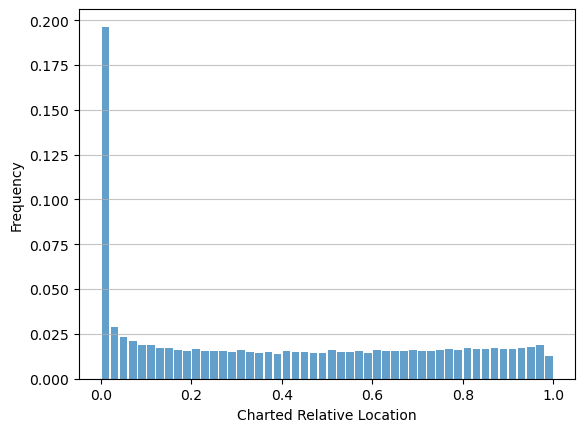

In [68]:
relative_placements = get_optimal_relative_placement_data(b, index_to_csn)
print(len(relative_placements))
weights = np.ones_like(relative_placements)/float(len(relative_placements))
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85, weights=weights)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

25930it [00:00, 88124.06it/s]


99754


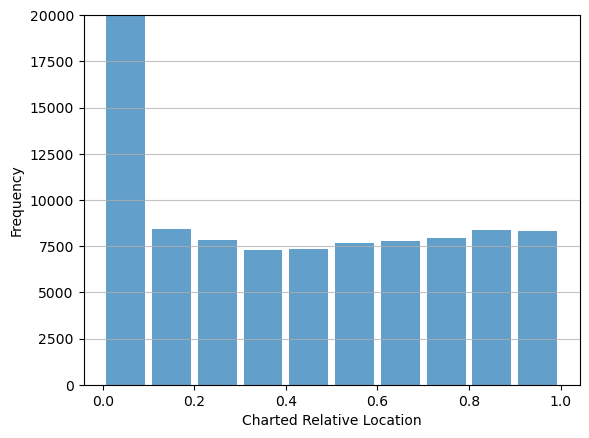

In [27]:
relative_placements = get_optimal_relative_placement_data(b, index_to_csn)
print(len(relative_placements))
plt.hist(relative_placements, bins=10, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.ylim([0, 20000])
plt.show()

### HR

In [24]:
df_optimal = pd.read_csv("/deep/group/physiologic-states/v3/optimizing_coverage.optimal.hr.csv")
print(df_optimal.shape)
df_optimal.head(3)

(25940, 12)


,CSN,orig_len,orig_covered,orig_total,orig_coverage,best_len,best_covered,best_total,best_coverage,HR_covered,HR_total,runtime
0,131307113250,3,179,310,0.577419,3,254,309,0.822006,254,310,119.385040
1,131305881124,2,35,53,0.660377,2,45,53,0.849057,45,53,1.414991
2,131308218446,4,124,147,0.843537,4,147,147,1.000000,147,147,15.513437


In [25]:
index_to_csn = {}
for k, row in df_optimal.iterrows():
    index_to_csn[k] = row["CSN"]

In [26]:
with open("/deep/group/physiologic-states/v3/optimizing_coverage.optimal.hr.pkl", 'rb') as f: 
    b = pickle.loads(f.read())
    print(b.keys())

dict_keys(['output_times'])


25940it [00:00, 89294.86it/s]


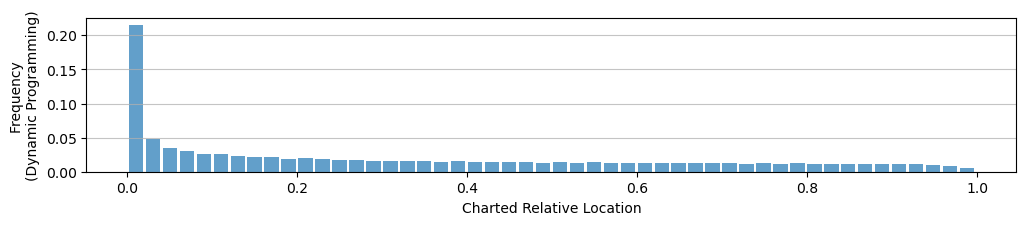

In [31]:
relative_placements = get_optimal_relative_placement_data(b, index_to_csn)

a4_dims = (12, 2)
fig, ax = plt.subplots(figsize=a4_dims)
weights = np.ones_like(relative_placements)/float(len(relative_placements))
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85, weights=weights)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency \n(Dynamic Programming)')
# plt.ylim([0, 0.25])
plt.show()

25940it [00:00, 100687.64it/s]


104021


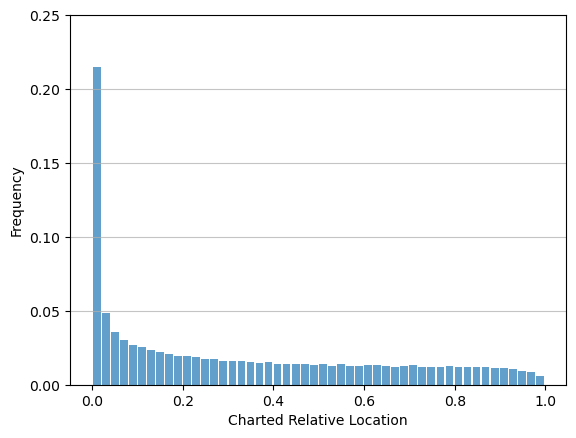

In [85]:
relative_placements = get_optimal_relative_placement_data(b, index_to_csn)
print(len(relative_placements))
weights = np.ones_like(relative_placements)/float(len(relative_placements))
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85, weights=weights)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.ylim([0, 0.25])
plt.show()

25940it [00:00, 75148.77it/s]


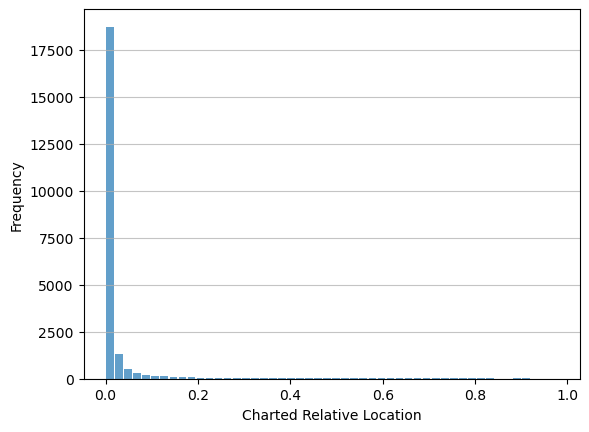

In [128]:
relative_placements = get_optimal_relative_placement_data_at_index(b, index_to_csn, 0)
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

25940it [00:00, 70739.86it/s]


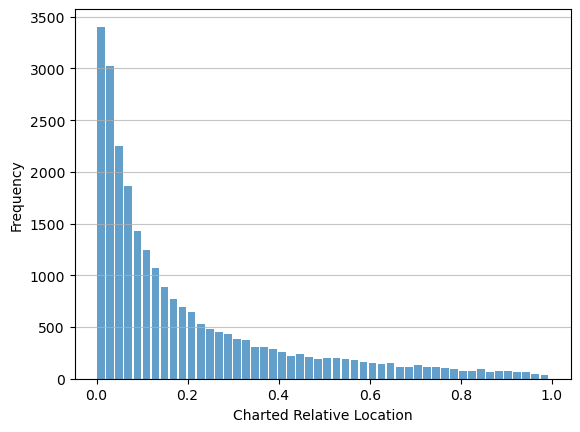

In [129]:
relative_placements = get_optimal_relative_placement_data_at_index(b, index_to_csn, 1)
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

### RR

In [130]:
df_optimal = pd.read_csv("/deep/group/physiologic-states/v3/optimizing_coverage.optimal.rr.csv")
print(df_optimal.shape)
df_optimal.head(3)

(25864, 12)


,CSN,orig_len,orig_covered,orig_total,orig_coverage,best_len,best_covered,best_total,best_coverage,RR_covered,RR_total,runtime
0,131293745562,3,54,197,0.274112,3,122,197,0.619289,122,197,29.410137
1,131295260109,6,64,160,0.400000,6,154,160,0.962500,154,160,17.611413
2,131309423975,2,123,137,0.897810,2,132,136,0.970588,80,137,14.042708


In [131]:
index_to_csn = {}
for k, row in df_optimal.iterrows():
    index_to_csn[k] = row["CSN"]

In [132]:
with open("/deep/group/physiologic-states/v3/optimizing_coverage.optimal.rr.pkl", 'rb') as f: 
    b = pickle.loads(f.read())
    print(b.keys())

dict_keys(['output_times'])


25864it [00:00, 47715.69it/s]


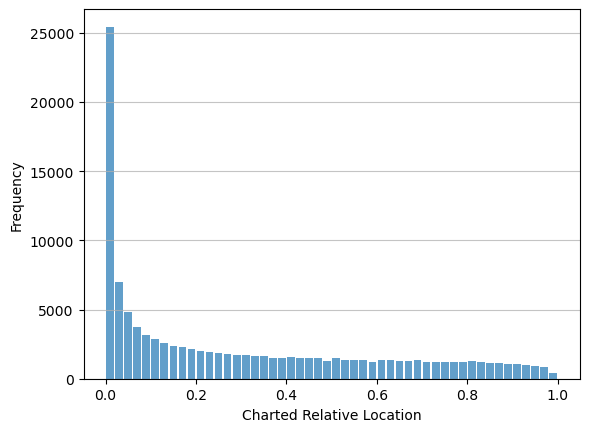

In [133]:
relative_placements = get_optimal_relative_placement_data(b, index_to_csn)
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

### SpO2

In [134]:
df_optimal = pd.read_csv("/deep/group/physiologic-states/v3/optimizing_coverage.optimal.spo2.csv")
print(df_optimal.shape)
df_optimal.head(3)

(25921, 12)


,CSN,orig_len,orig_covered,orig_total,orig_coverage,best_len,best_covered,best_total,best_coverage,SpO2_covered,SpO2_total,runtime
0,131300927769,3,216,228,0.947368,3,224,228,0.982456,224,228,38.987413
1,131318008939,3,89,89,1.000000,3,89,89,1.000000,89,89,3.539781
2,131299692977,3,225,227,0.991189,1,227,227,1.000000,227,227,41.751920


In [135]:
index_to_csn = {}
for k, row in df_optimal.iterrows():
    index_to_csn[k] = row["CSN"]

In [136]:
with open("/deep/group/physiologic-states/v3/optimizing_coverage.optimal.spo2.pkl", 'rb') as f: 
    b = pickle.loads(f.read())
    print(b.keys())

dict_keys(['output_times'])


25921it [00:00, 54043.12it/s]


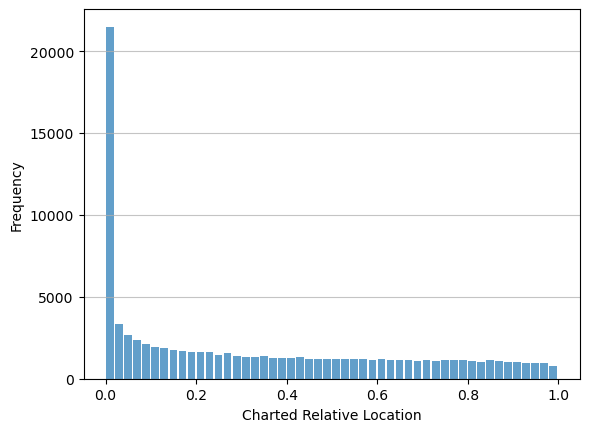

In [137]:
relative_placements = get_optimal_relative_placement_data(b, index_to_csn)
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

### MAP

In [138]:
df_optimal = pd.read_csv("/deep/group/physiologic-states/v3/optimizing_coverage.optimal.map.csv")
print(df_optimal.shape)
df_optimal.head(3)

(24532, 12)


,CSN,orig_len,orig_covered,orig_total,orig_coverage,best_len,best_covered,best_total,best_coverage,MAP_covered,MAP_total,runtime
0,131309115537,2,76,76,1.00,1,76,76,1.0,76,76,2.295320
1,131311166697,3,9,9,1.00,1,9,9,1.0,9,9,0.196519
2,131309113876,2,21,50,0.42,2,35,50,0.7,35,50,1.027970


In [139]:
index_to_csn = {}
for k, row in df_optimal.iterrows():
    index_to_csn[k] = row["CSN"]

In [140]:
with open("/deep/group/physiologic-states/v3/optimizing_coverage.optimal.map.pkl", 'rb') as f: 
    b = pickle.loads(f.read())
    print(b.keys())

dict_keys(['output_times'])


24532it [00:00, 54398.36it/s]


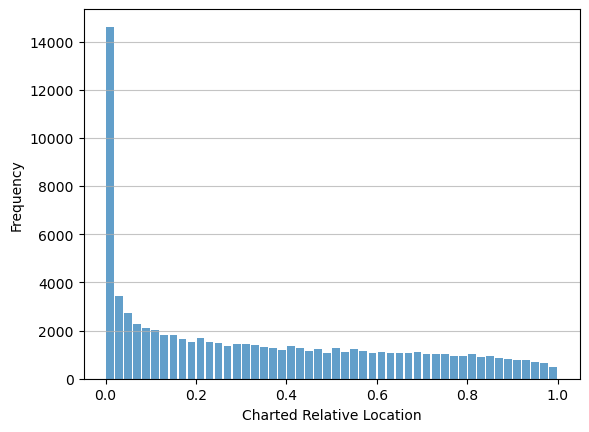

In [141]:
relative_placements = get_optimal_relative_placement_data(b, index_to_csn)
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

## Population Charted Event Placement

In [142]:
def get_population_relative_placement_data(b, index_to_csn):
    relative_placements = []
    csn_to_index = {}

    for i, row in tqdm(enumerate(b["output_times"])):
        csn = index_to_csn[i]
        min_time = csn_to_min_time[csn].replace(tzinfo=None)
        max_time = csn_to_max_time[csn].replace(tzinfo=None)
        
        for time in row:
            time = time.replace(tzinfo=None)
            if time < min_time or time > max_time:
                # Ignore any measures that weren't in the monitoring bounds
                continue

            time_since_arrival = (time - min_time).total_seconds()
            total_time = (max_time - min_time).total_seconds()

            if total_time > 0:
                relative_time = time_since_arrival / total_time
                relative_placements.append(relative_time)

    return relative_placements
    

### All

In [143]:
df_optimal = pd.read_csv("/deep/group/physiologic-states/v3/optimizing_coverage_population.optimal.csv")
print(df_optimal.shape)
df_optimal.head(3)

(25830, 18)


,CSN,orig_len,orig_covered,orig_total,orig_coverage,best_len,best_covered,best_total,best_coverage,HR_covered,HR_total,RR_covered,RR_total,SpO2_covered,SpO2_total,MAP_covered,MAP_total,runtime
0,131305340187,6,718,1190,0.603361,6,1049,1190,0.881513,281,298,265,293,276,304,227,295,63.234995
1,131295823551,4,683,1130,0.604425,4,922,1130,0.815929,199,217,142,217,260,351,321,345,69.240899
2,131318324804,3,321,371,0.865229,3,353,371,0.951482,98,102,89,102,102,102,64,65,22.002185


In [144]:
index_to_csn = {}
for k, row in df_optimal.iterrows():
    index_to_csn[k] = row["CSN"]

In [145]:
with open("/deep/group/physiologic-states/v3/optimizing_coverage_population.optimal.pkl", 'rb') as f: 
    b = pickle.loads(f.read())
    print(b.keys())

dict_keys(['output_times'])


25830it [00:00, 41290.32it/s]


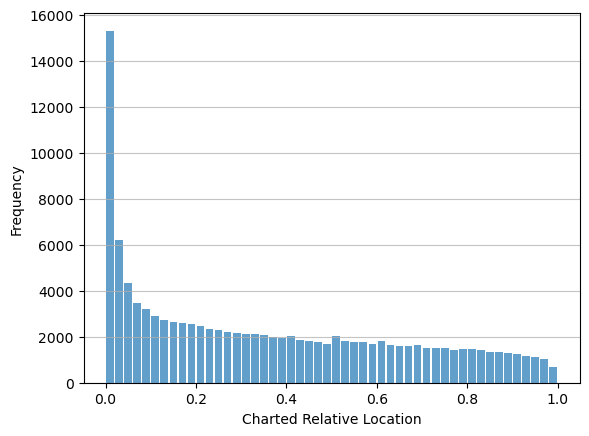

In [146]:
relative_placements = get_optimal_relative_placement_data(b, index_to_csn)
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.show()

### HR

In [40]:
df_optimal = pd.read_csv("/deep/group/physiologic-states/v3/optimizing_coverage_population.optimal.hr.csv")
print(df_optimal.shape)
df_optimal.head(3)

(25791, 12)


,CSN,orig_len,orig_covered,orig_total,orig_coverage,best_len,best_covered,best_total,best_coverage,HR_covered,HR_total,runtime
0,131313966405,3,61,86,0.709302,3,68,86,0.790698,68,86,6.365554
1,131296982741,5,72,130,0.553846,5,106,130,0.815385,106,130,8.221853
2,131295712574,4,61,160,0.381250,4,153,160,0.956250,153,160,12.300475


In [41]:
index_to_csn = {}
for k, row in df_optimal.iterrows():
    index_to_csn[k] = row["CSN"]

In [42]:
with open("/deep/group/physiologic-states/v3/optimizing_coverage_population.optimal.hr.pkl", 'rb') as f: 
    b = pickle.loads(f.read())
    print(b.keys())

dict_keys(['output_times'])


25791it [00:00, 96773.27it/s]


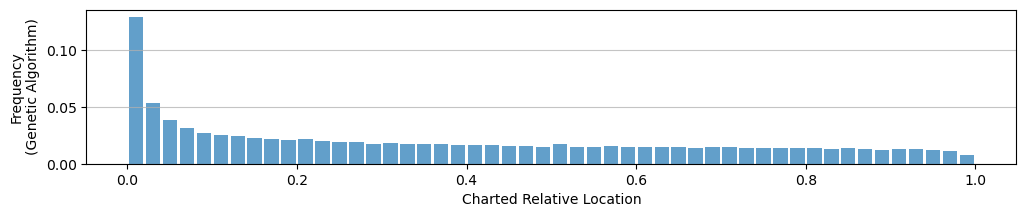

In [43]:
relative_placements = get_optimal_relative_placement_data(b, index_to_csn)

a4_dims = (12, 2)
fig, ax = plt.subplots(figsize=a4_dims)
weights = np.ones_like(relative_placements)/float(len(relative_placements))
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85, weights=weights)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency\n(Genetic Algorithm)')
# plt.ylim([0, 0.25])
plt.show()

25791it [00:00, 78406.76it/s]


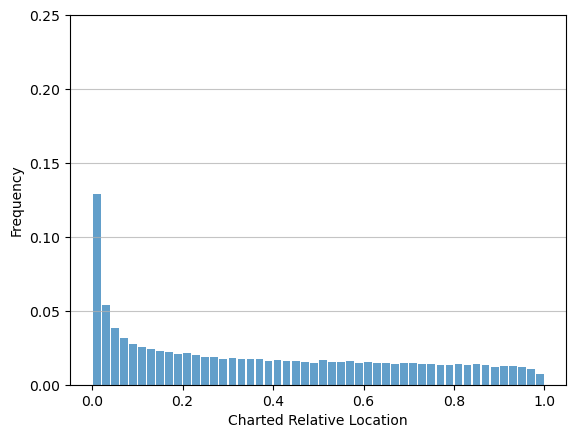

In [89]:
relative_placements = get_optimal_relative_placement_data(b, index_to_csn)
weights = np.ones_like(relative_placements)/float(len(relative_placements))
plt.hist(relative_placements, bins=50, alpha=0.7, rwidth=0.85, weights=weights)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Charted Relative Location')
plt.ylabel('Frequency')
plt.ylim([0, 0.25])
plt.show()